# `l2hmc-qcd`

This notebook contains a minimal working example for the 4D SU(3) Model

Uses `torch.complex128` by default

## Setup

In [1]:
! nvidia-smi | tail --lines -7

+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|    2   N/A  N/A   2714602      C   ...PU/2023-04-26/bin/python3    11349MiB |
+-----------------------------------------------------------------------------+


In [2]:
# automatically detect and reload local changes to modules
%load_ext autoreload
%autoreload 2

In [3]:
import os
# --------------------------------------
# BE SURE TO GRAB A FRESH GPU !
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
#!echo $CUDA_VISIBLE_DEVICES
# --------------------------------------

In [4]:
#devices = os.environ.get('CUDA_VISIBLE_DEVICES', None)
#print(devices)
!getconf _NPROCESSORS_ONLN

256


In [6]:
from __future__ import absolute_import, print_function, annotations, division

import warnings

import torch
import numpy as np

from hydra.core.global_hydra import GlobalHydra

warnings.filterwarnings('ignore')

os.environ['MASTER_PORT'] = '12345'
#os.environ['OMP_NUM_THREADS'] = '256'

np.set_printoptions(threshold=5)
torch.set_printoptions(threshold=5, precision=5)

In [7]:
from l2hmc.utils.dist import (
    setup_torch
)
_ = setup_torch(
    precision='float64',
    backend='DDP',
    seed=1234,
)

--------------------------------------------------------------------------

  Local host:   thetagpu23
  Local device: mlx5_0
--------------------------------------------------------------------------


[06/04/23 22:36:48][INFO][dist.py:226] - Caught MASTER_PORT:12345 from environment!
[06/04/23 22:36:48][WARNING][dist.py:332] - Setting default dtype: float64
[06/04/23 22:36:48][INFO][dist.py:338] - Global Rank: 0 / 0


In [8]:
from l2hmc.experiment.pytorch.experiment import Experiment as ptExperiment

import l2hmc.group.su3.pytorch.group as gpt
ptsu3 = gpt.SU3()

import l2hmc
l2hmc.__file__

2023-06-04 22:36:48.639489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'/lus/grand/projects/datascience/foremans/locations/thetaGPU/projects/saforem2/l2hmc-qcd/src/l2hmc/__init__.py'

In [9]:
%matplotlib widget
import matplotlib.pyplot as plt

from l2hmc.common import grab_tensor, print_dict
from l2hmc.utils.plot_helpers import set_plot_style

set_plot_style()

from l2hmc.utils.plot_helpers import (  # noqa
    set_plot_style,
    plot_scalar,
    plot_chains,
    plot_leapfrogs
)


def plot_metrics(metrics: dict, title: Optional[str] = None):
    for key, val in metrics.items():
        fig, ax = plot_metric(val, name=key)
        if title is not None:
            ax.set_title(title)


def plot_metric(
        metric: torch.Tensor,
        name: Optional[str] = None,
):
    assert len(metric) > 0
    if isinstance(metric[0], (int, float, bool, np.floating)):
        y = np.stack(metric)
        return plot_scalar(y, ylabel=name)
    element_shape = metric[0].shape
    if len(element_shape) == 2:
        y = grab_tensor(torch.stack(metric))
        return plot_leapfrogs(y, ylabel=name)
    if len(element_shape) == 1:
        y = grab_tensor(torch.stack(metric))
        return plot_chains(y, ylabel=name)
    if len(element_shape) == 0:
        y = grab_tensor(torch.stack(metric))
        return plot_scalar(y, ylabel=name)
    raise ValueError

## Specify defaults for building Experiment

In [10]:
GlobalHydra.instance().clear()

In [11]:
DEFAULTS = {
    'save': False,
    'restore': False,
    'init_aim': False,
    'init_wandb': False,
    'use_wandb': False,
    'use_tb': False,
    'backend': 'DDP',
    'framework': 'pytorch',
    'conv': 'none',
    'network': {
        'use_batch_norm': False,
        'activation_fn': 'tanh',
        'dropout_prob': 0.0,
        'units': [1],
    },
    'dynamics': {
        'group': 'SU3',
        'eps': 0.1,
        'nchains': 2,
        'nleapfrog': 2,
        'verbose': True,
        'latvolume': [4, 4, 4, 4],
        'eps_fixed': False,
    },
    'net_weights': {
        'x': {
            's': 0.0,
            't': 1.0,
            'q': 1.0,
        },
        'v': {
            's': 1.0,
            't': 1.0,
            'q': 1.0,
        },
    },
    'loss': {
        'rmse_weight': 1.0,
        'plaq_weight': 0.0,
        'charge_weight': 0.0,
        'use_mixed_loss': False,
    },
    'steps': {
        'nera': 1,
        'nepoch': 10,
        'test': 50,
        'print': 1,
        'log': 1,
    },
    'learning_rate': {
        'lr_init': 0.00001,
        'clip_norm': float(1e-16),
    },
    'annealing_schedule': {
        'beta_init': 6.0,
        'beta_final': 6.0,
    },
}

In [12]:
try:
    import gc
    import GPUtil

    gc.collect()
    with torch.no_grad():
        torch.cuda.empty_cache()
    torch.clear_autocast_cache()
    GPUtil.showUtilization()
except ImportError:
    pass

## Build Experiment

In [13]:
from l2hmc.configs import dict_to_list_of_overrides
OVERRIDES = dict_to_list_of_overrides(DEFAULTS)
OVERRIDES

['save=False',
 'restore=False',
 'init_aim=False',
 'init_wandb=False',
 'use_wandb=False',
 'use_tb=False',
 'backend=DDP',
 'framework=pytorch',
 'conv=none',
 'network.use_batch_norm=False',
 'network.activation_fn=tanh',
 'network.dropout_prob=0.0',
 'network.units=[1]',
 'dynamics.group=SU3',
 'dynamics.eps=0.1',
 'dynamics.nchains=2',
 'dynamics.nleapfrog=2',
 'dynamics.verbose=True',
 'dynamics.latvolume=[4, 4, 4, 4]',
 'dynamics.eps_fixed=False',
 'net_weights.x.s=0.0',
 'net_weights.x.t=1.0',
 'net_weights.x.q=1.0',
 'net_weights.v.s=1.0',
 'net_weights.v.t=1.0',
 'net_weights.v.q=1.0',
 'loss.rmse_weight=1.0',
 'loss.plaq_weight=0.0',
 'loss.charge_weight=0.0',
 'loss.use_mixed_loss=False',
 'steps.nera=1',
 'steps.nepoch=10',
 'steps.test=50',
 'steps.print=1',
 'steps.log=1',
 'learning_rate.lr_init=1e-05',
 'learning_rate.clip_norm=1e-16',
 'annealing_schedule.beta_init=6.0',
 'annealing_schedule.beta_final=6.0']

In [14]:
from l2hmc.configs import get_experiment  # noqa
from l2hmc.configs import dict_to_list_of_overrides

GlobalHydra.instance().clear()

OVERRIDES = dict_to_list_of_overrides(DEFAULTS)

ptExpSU3 = get_experiment(
    overrides=[
        *OVERRIDES,
    ],
    build_networks=True,
)

[06/04/23 22:44:58][INFO][dist.py:226] - Caught MASTER_PORT:12345 from environment!
[06/04/23 22:44:58][INFO][dist.py:226] - Caught MASTER_PORT:12345 from environment!
[06/04/23 22:44:59][WARNING][trainer.py:419] - Using `torch.optim.Adam` optimizer
[06/04/23 22:44:59][INFO][trainer.py:275] - num_params in model: 622608
[06/04/23 22:44:59][WARNING][trainer.py:242] - logging with freq 1 for wandb.watch


## Evaluate

In [15]:
state = ptExpSU3.trainer.dynamics.random_state(6.0)
x0 = state.x

In [16]:
x0.dtype

torch.complex128

### HMC

In [17]:
from l2hmc.experiment.pytorch.experiment import evaluate  # noqa

xhmc, history_hmc = evaluate(
    nsteps=100,
    exp=ptExpSU3,
    beta=6.0,
    x=x0,
    eps=0.1,
    nleapfrog=4,
    job_type='hmc',
    nlog=2,
    nprint=25,
    grab=True
)

[06/04/23 22:45:08][INFO][experiment.py:58] - Running 100 steps of hmc at beta=6.0000
[06/04/23 22:45:08][INFO][experiment.py:62] - STEP: 0
[06/04/23 22:45:08][INFO][experiment.py:62] - STEP: 1
[06/04/23 22:45:08][INFO][experiment.py:62] - STEP: 2
[06/04/23 22:45:09][INFO][experiment.py:62] - STEP: 3
[06/04/23 22:45:09][INFO][experiment.py:62] - STEP: 4
[06/04/23 22:45:09][INFO][experiment.py:62] - STEP: 5
[06/04/23 22:45:09][INFO][experiment.py:62] - STEP: 6
[06/04/23 22:45:10][INFO][experiment.py:62] - STEP: 7
[06/04/23 22:45:10][INFO][experiment.py:62] - STEP: 8
[06/04/23 22:45:10][INFO][experiment.py:62] - STEP: 9
[06/04/23 22:45:10][INFO][experiment.py:62] - STEP: 10
[06/04/23 22:45:10][INFO][experiment.py:62] - STEP: 11
[06/04/23 22:45:11][INFO][experiment.py:62] - STEP: 12
[06/04/23 22:45:11][INFO][experiment.py:62] - STEP: 13
[06/04/23 22:45:11][INFO][experiment.py:62] - STEP: 14
[06/04/23 22:45:11][INFO][experiment.py:62] - STEP: 15
[06/04/23 22:45:12][INFO][experiment.py:62] 

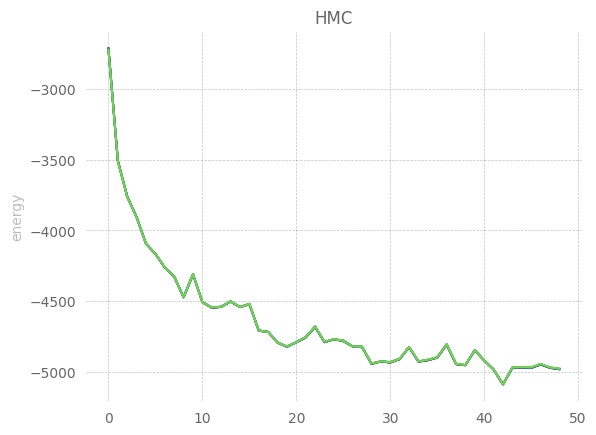

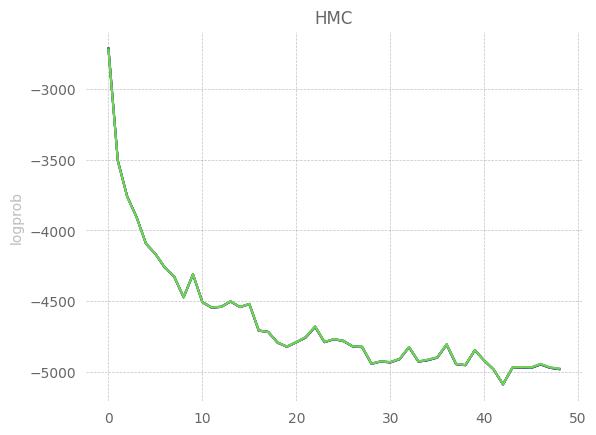

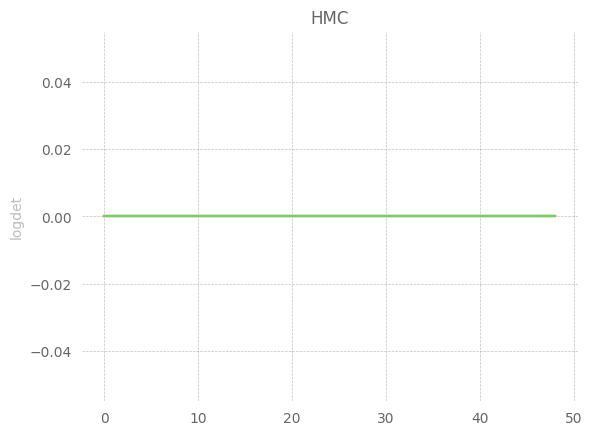

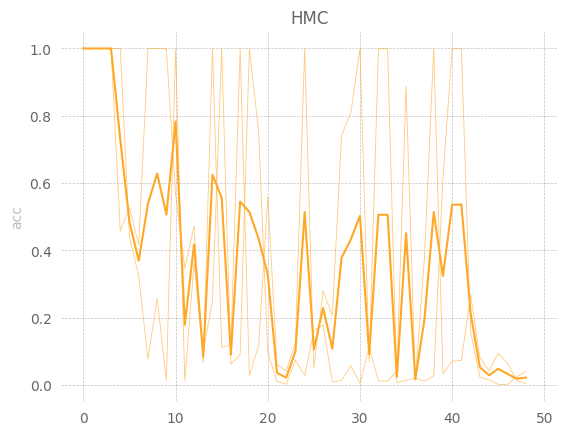

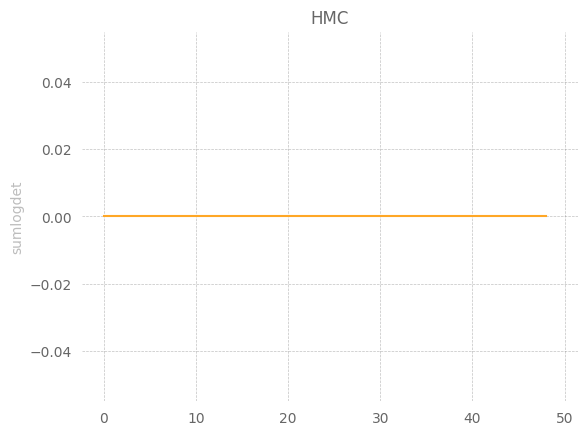

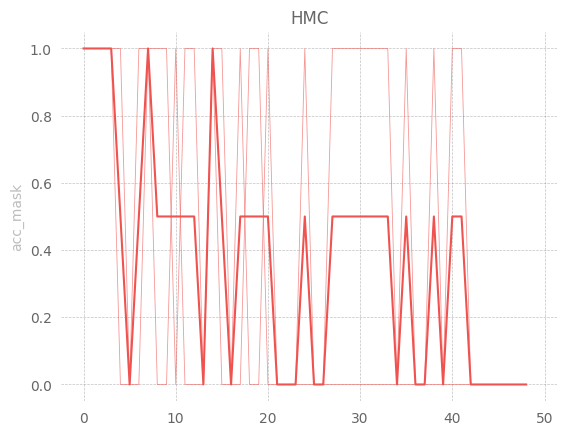

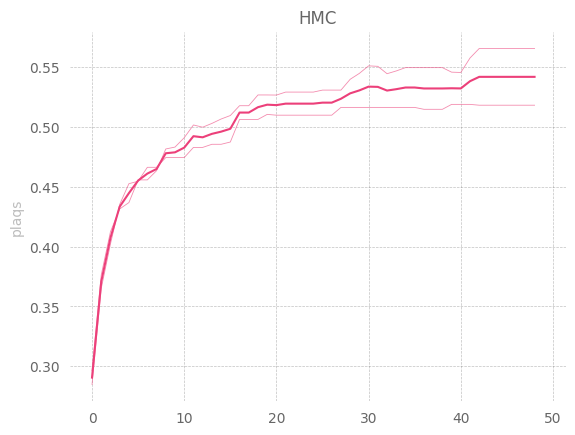

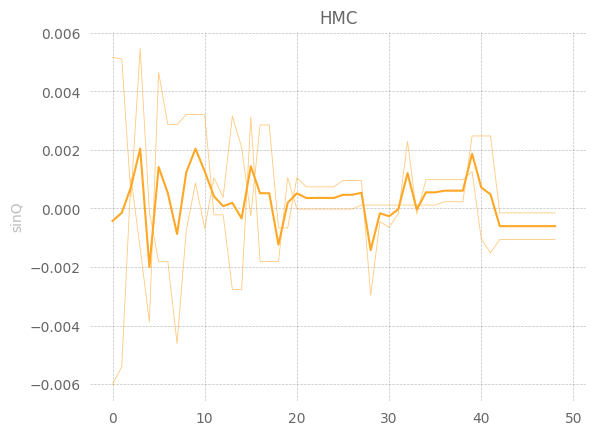

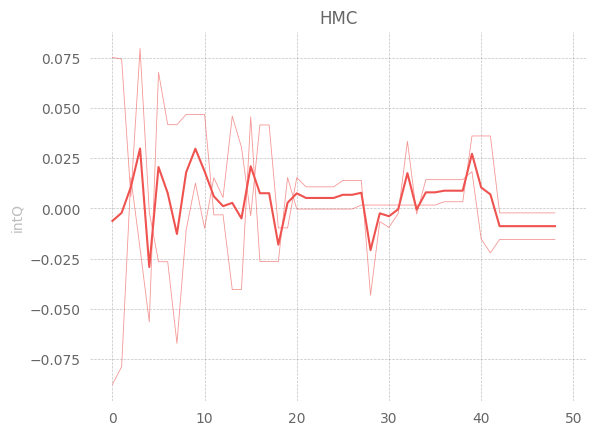

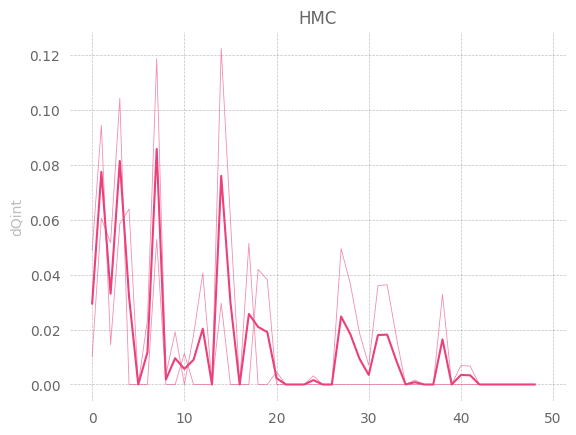

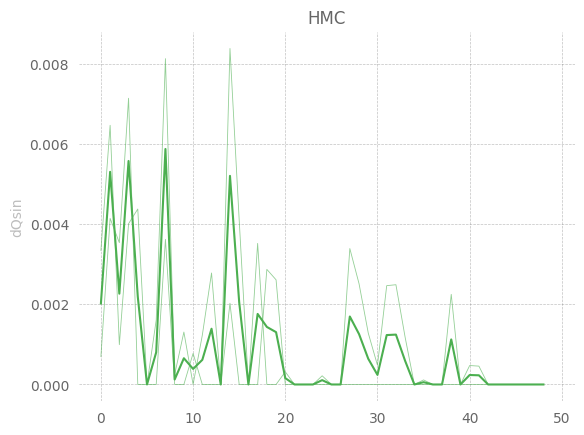

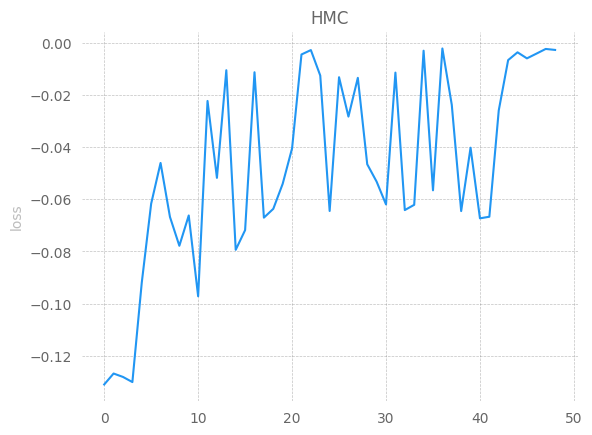

In [18]:
plot_metrics(history_hmc, title='HMC')

### Inference

In [19]:
ptExpSU3.trainer.dynamics.init_weights(
    method='uniform',
    min=-1e-36,
    max=1e-36,
    bias=True,
)

nlf = ptExpSU3.trainer.dynamics.config.nleapfrog
eps = torch.tensor(0.10)

#ptExpSU3.trainer.dynamics.xeps = torch.stack(
#    [
#        eps for _ in range(nlf)
#    ]
#)
#ptExpSU3.trainer.dynamics.veps = torch.stack(
#    [
#        eps for _ in range(nlf)
#    ]
#)

In [20]:
np.set_printoptions(precision=5)
torch.set_printoptions(precision=5)

In [21]:
_ = print_dict({
    k: v for k, v in ptExpSU3.trainer.dynamics.named_parameters()
}, grab=False)

[06/04/23 22:45:34][INFO][common.py:97] - networks.xnet.0.first.input_layer.xlayer.weight: Parameter containing:
tensor([[-5.97542e-37, -4.24573e-40,  8.70996e-37,  ..., -1.50846e-37,
         -9.55721e-37,  1.57729e-37]], device='cuda:0', requires_grad=True)
networks.xnet.0.first.input_layer.xlayer.bias: Parameter containing:
tensor([-2.02794e-37], device='cuda:0', requires_grad=True)
networks.xnet.0.first.input_layer.vlayer.weight: Parameter containing:
tensor([[-2.00628e-37, -5.01265e-37, -5.67475e-37,  ...,  5.30561e-37,
          4.43353e-37, -3.70981e-37]], device='cuda:0', requires_grad=True)
networks.xnet.0.first.input_layer.vlayer.bias: Parameter containing:
tensor([-3.81124e-37], device='cuda:0', requires_grad=True)
networks.xnet.0.first.scale.coeff: Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)
networks.xnet.0.first.scale.layer.weight: Parameter containing:
tensor([[ 3.17579e-37],
        [ 4.89025e-37],
        [ 3.03749

In [22]:
from l2hmc.experiment.pytorch.experiment import evaluate  # noqa

#ptExpSU3.trainer.dynamics.init_weights()
#    #constant=np.random.randn() / 1e10
#    constant=0.0,
#)

xeval, history_eval = evaluate(
    nsteps=100,
    exp=ptExpSU3,
    beta=6.0,
    x=x0,
    job_type='eval',
    nlog=2,
    nprint=25,
    grab=True,
)

[06/04/23 22:45:34][INFO][experiment.py:58] - Running 100 steps of eval at beta=6.0000
[06/04/23 22:45:34][INFO][experiment.py:62] - STEP: 0
[06/04/23 22:45:34][INFO][experiment.py:62] - STEP: 1
[06/04/23 22:45:35][INFO][experiment.py:62] - STEP: 2
[06/04/23 22:45:35][INFO][experiment.py:62] - STEP: 3
[06/04/23 22:45:35][INFO][experiment.py:62] - STEP: 4
[06/04/23 22:45:36][INFO][experiment.py:62] - STEP: 5
[06/04/23 22:45:36][INFO][experiment.py:62] - STEP: 6
[06/04/23 22:45:37][INFO][experiment.py:62] - STEP: 7
[06/04/23 22:45:37][INFO][experiment.py:62] - STEP: 8
[06/04/23 22:45:37][INFO][experiment.py:62] - STEP: 9
[06/04/23 22:45:38][INFO][experiment.py:62] - STEP: 10
[06/04/23 22:45:38][INFO][experiment.py:62] - STEP: 11
[06/04/23 22:45:39][INFO][experiment.py:62] - STEP: 12
[06/04/23 22:45:39][INFO][experiment.py:62] - STEP: 13
[06/04/23 22:45:39][INFO][experiment.py:62] - STEP: 14
[06/04/23 22:45:40][INFO][experiment.py:62] - STEP: 15
[06/04/23 22:45:40][INFO][experiment.py:62]

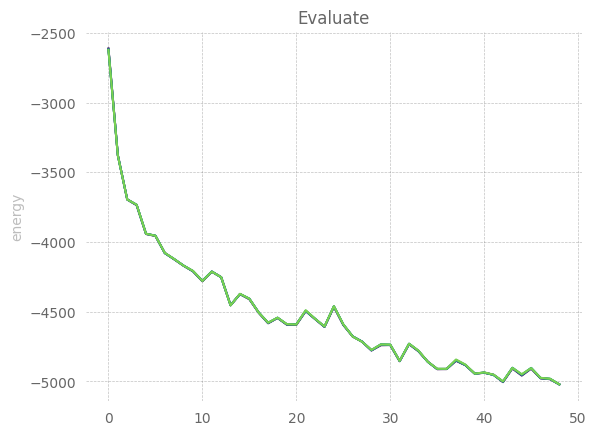

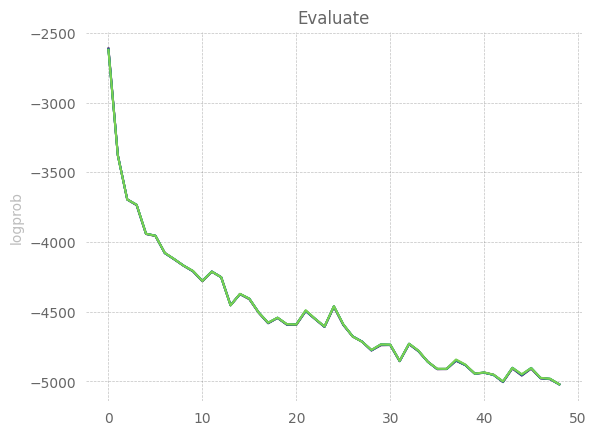

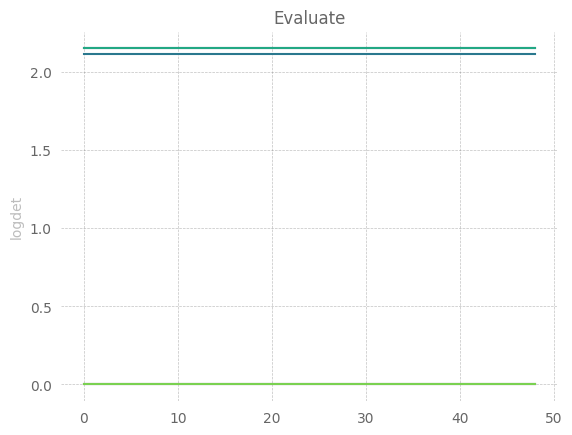

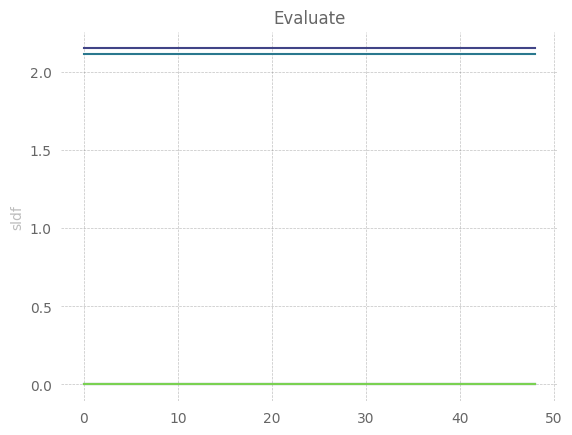

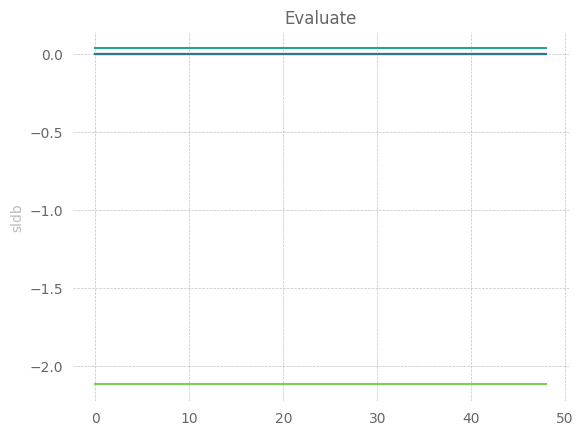

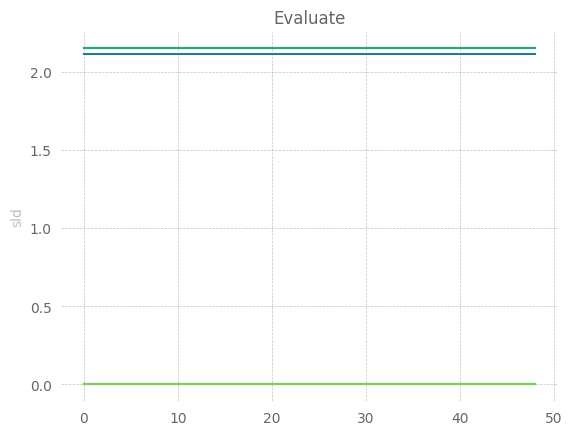

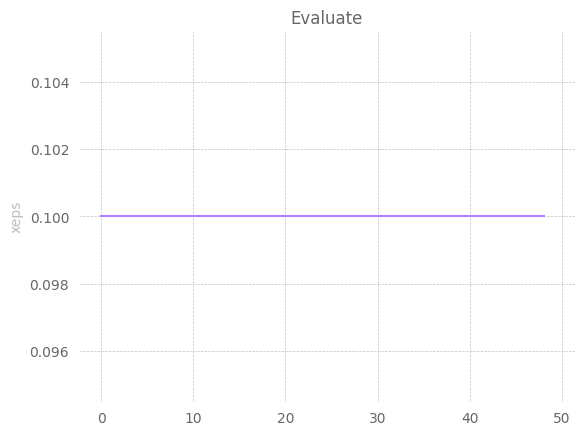

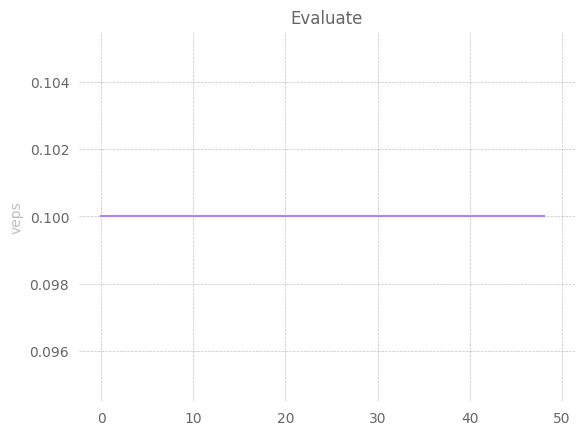

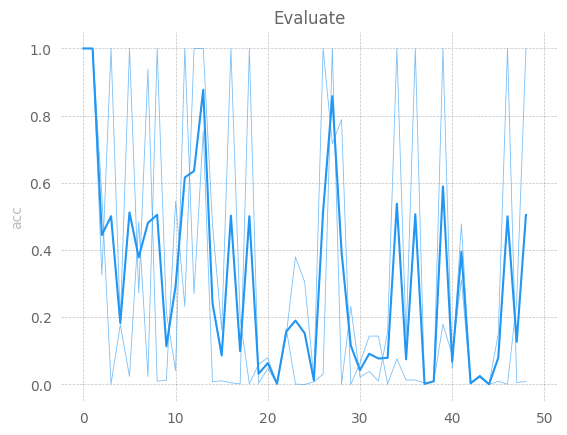

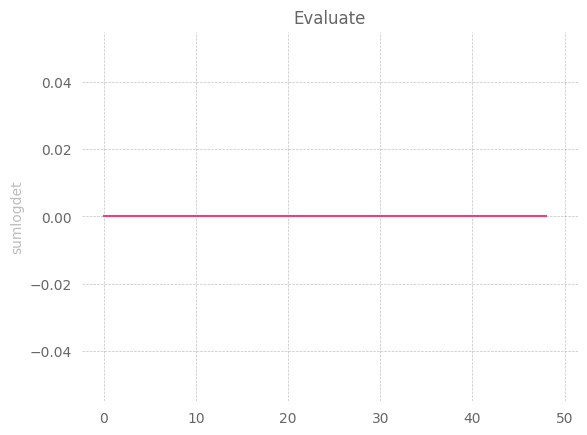

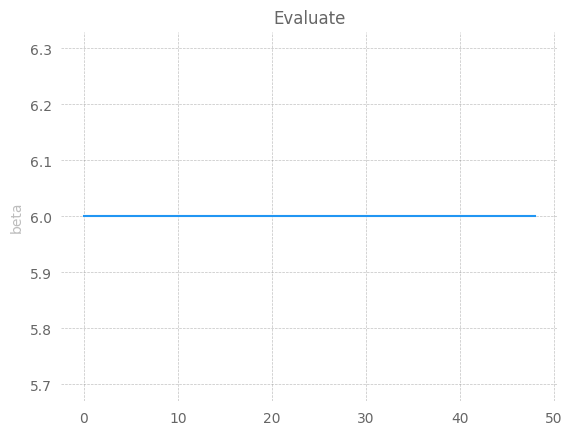

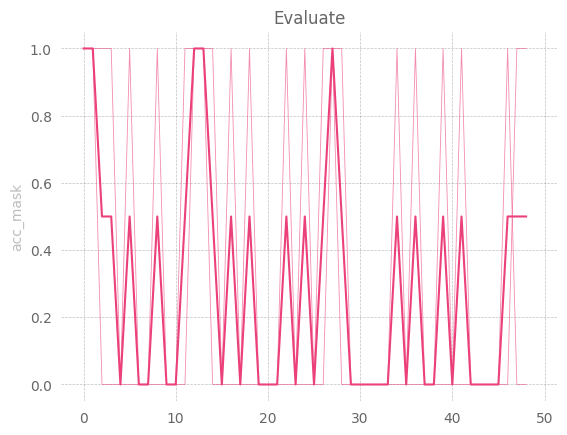

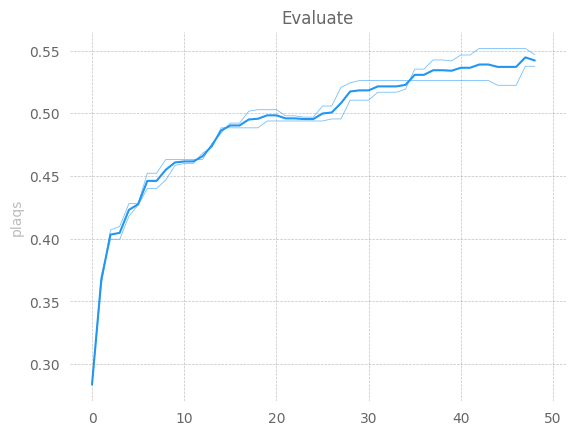

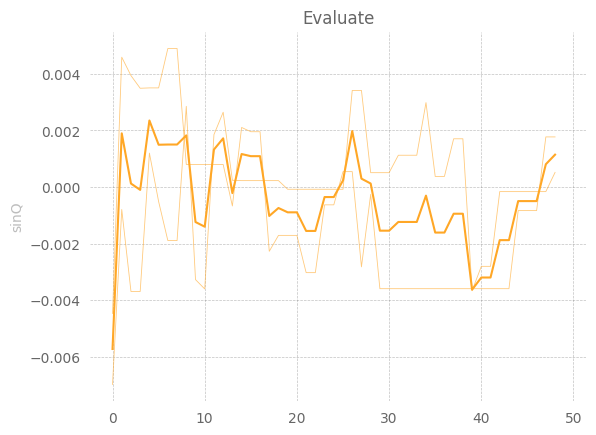

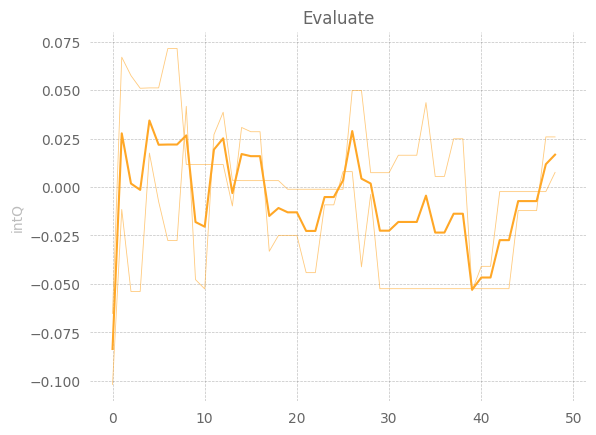

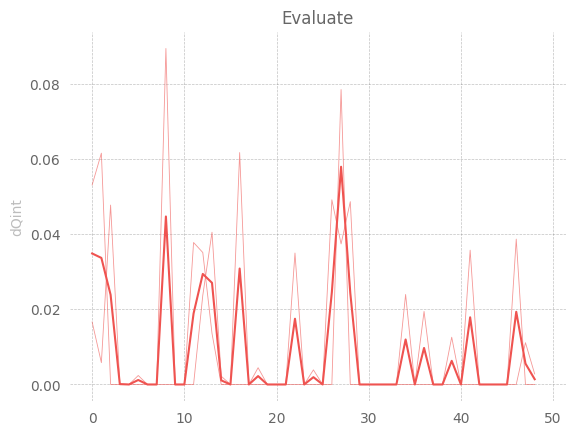

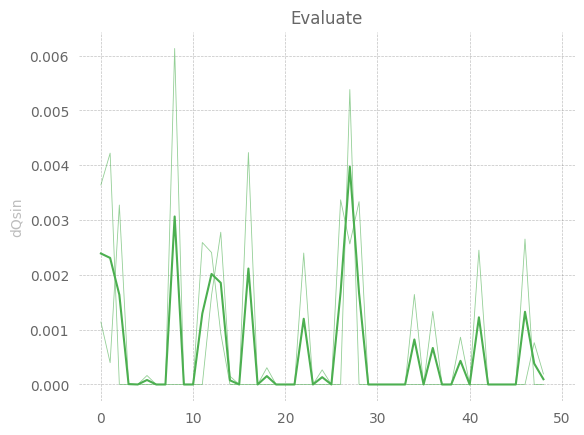

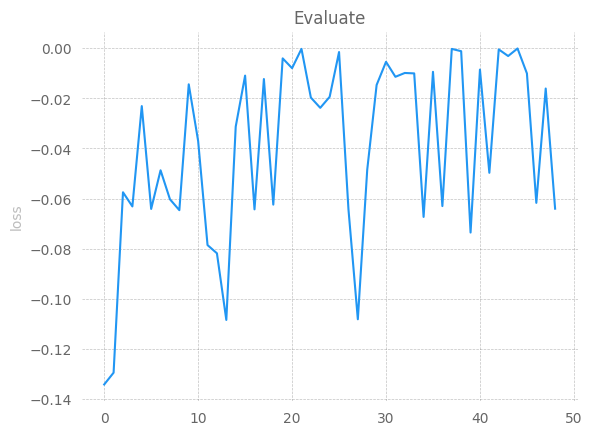

In [23]:
plot_metrics(history_eval, title='Evaluate')

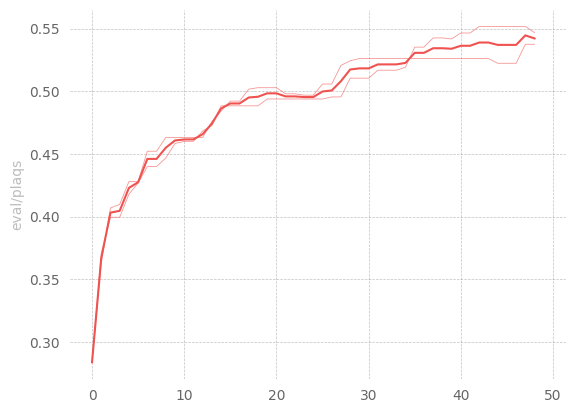

In [24]:
_ = plot_metric(history_eval['plaqs'], name='eval/plaqs')

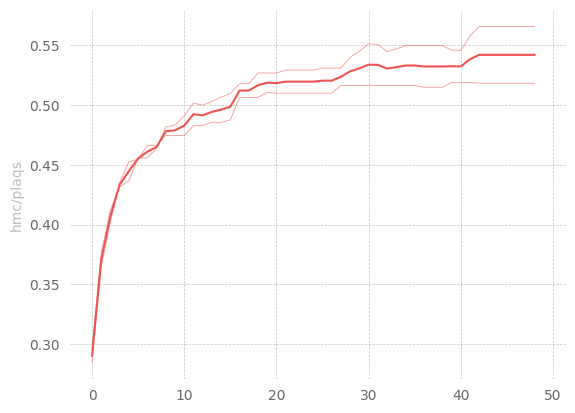

In [25]:
_ = plot_metric(history_hmc['plaqs'], name='hmc/plaqs')

In [26]:
pratio = [
    ph / pe for (pe, ph) in zip(history_hmc['plaqs'], history_eval['plaqs'])
]
pdiff = [
    (ph - pe).abs() for (pe, ph) in zip(history_hmc['plaqs'], history_eval['plaqs'])
]

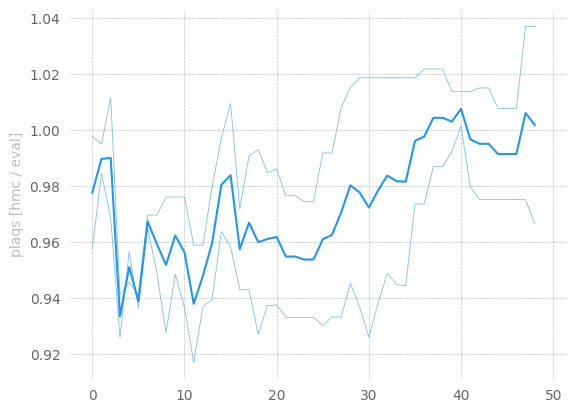

In [27]:
_ = plot_metric(pratio, name='plaqs [hmc / eval]')

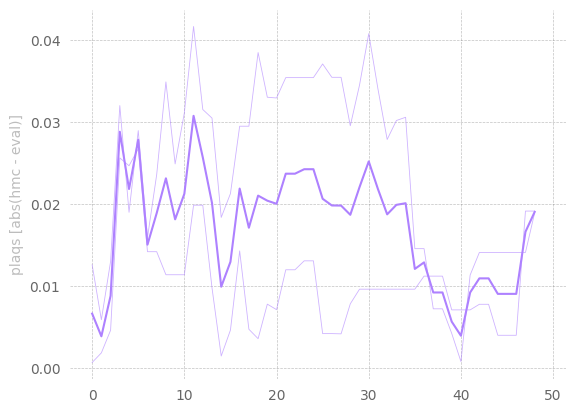

In [28]:
_ = plot_metric(pdiff, name='plaqs [abs(hmc - eval)]')

### Training

In [29]:
import torch
from l2hmc.trainers.pytorch.trainer import Trainer  # noqa

def calc_loss(
        x: torch.Tensor,
        y: torch.Tensor,
        acc: torch.Tensor
) -> torch.Tensor:
    dx = (x - y)
    dx2 = (dx.real.pow(2) + dx.imag.pow(2)).flatten(1)
    return (acc * dx2.mean(1)).sum()


def train_step(
        x: torch.Tensor,
        beta: float | torch.Tensor,
        trainer: Trainer,
) -> tuple[torch.Tensor, dict]:
    if isinstance(beta, float):
        beta = torch.tensor(beta)
    x.requires_grad_(True)
    trainer.optimizer.zero_grad()
    xout, metrics = trainer.dynamics_engine((x, beta))
    xprop = metrics.pop('mc_states').proposed.x
    loss = calc_loss(x, xprop, metrics['acc'])
    #loss = trainer.backward_step(loss)
    #dx = (x - xprop).abs().flatten(1).mean(-1)
    #loss = (metrics['acc'] * dx).mean()
    #loss = trainer.calc_loss(
    #    xinit=x,
    #    xprop=xprop,
    #    acc=metrics['acc']
    #)
    loss.backward()
    torch.nn.utils.clip_grad.clip_grad_norm(
        trainer.dynamics.parameters(),
        max_norm=float(1-16),
    )
    trainer.optimizer.step()
    metrics |= {'loss': loss.item()}
    print_dict(metrics, grab=False)
    return xout.detach(), metrics

# Individual Training Step

Look at params / gradients both _before_ and _after_ a single training step

## Weights & Grads (before)

In [30]:
trainer = ptExpSU3.trainer
dynamics = trainer.dynamics
_ = print_dict({
    k: v.grad for k, v in dynamics.named_parameters()
})

[06/04/23 22:46:19][INFO][common.py:97] - networks.xnet.0.first.input_layer.xlayer.weight: None
networks.xnet.0.first.input_layer.xlayer.bias: None
networks.xnet.0.first.input_layer.vlayer.weight: None
networks.xnet.0.first.input_layer.vlayer.bias: None
networks.xnet.0.first.scale.coeff: None
networks.xnet.0.first.scale.layer.weight: None
networks.xnet.0.first.scale.layer.bias: None
networks.xnet.0.first.transf.coeff: None
networks.xnet.0.first.transf.layer.weight: None
networks.xnet.0.first.transf.layer.bias: None
networks.xnet.0.first.transl.weight: None
networks.xnet.0.first.transl.bias: None
networks.xnet.0.second.input_layer.xlayer.weight: None
networks.xnet.0.second.input_layer.xlayer.bias: None
networks.xnet.0.second.input_layer.vlayer.weight: None
networks.xnet.0.second.input_layer.vlayer.bias: None
networks.xnet.0.second.scale.coeff: None
networks.xnet.0.second.scale.layer.weight: None
networks.xnet.0.second.scale.layer.bias: None
networks.xnet.0.second.transf.coeff: None
netw

In [31]:
_ = print_dict({
    k: v for k, v in dynamics.named_parameters()
}, grab=False)

[06/04/23 22:46:19][INFO][common.py:97] - networks.xnet.0.first.input_layer.xlayer.weight: Parameter containing:
tensor([[-5.97542e-37, -4.24573e-40,  8.70996e-37,  ..., -1.50846e-37,
         -9.55721e-37,  1.57729e-37]], device='cuda:0', requires_grad=True)
networks.xnet.0.first.input_layer.xlayer.bias: Parameter containing:
tensor([-2.02794e-37], device='cuda:0', requires_grad=True)
networks.xnet.0.first.input_layer.vlayer.weight: Parameter containing:
tensor([[-2.00628e-37, -5.01265e-37, -5.67475e-37,  ...,  5.30561e-37,
          4.43353e-37, -3.70981e-37]], device='cuda:0', requires_grad=True)
networks.xnet.0.first.input_layer.vlayer.bias: Parameter containing:
tensor([-3.81124e-37], device='cuda:0', requires_grad=True)
networks.xnet.0.first.scale.coeff: Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)
networks.xnet.0.first.scale.layer.weight: Parameter containing:
tensor([[ 3.17579e-37],
        [ 4.89025e-37],
        [ 3.03749

## Train Step

In [33]:
beta = torch.tensor(6.0)
xout, metrics = train_step(x=x0, beta=beta, trainer=ptExpSU3.trainer)

[06/04/23 22:46:43][INFO][common.py:97] - energy: tensor([[-147.09419,   79.89714],
        [-150.16182,   77.11442],
        [-159.42762,   66.51201],
        [-177.35047,   48.54322],
        [-195.57014,   31.77608]], device='cuda:0', grad_fn=<StackBackward0>)
logprob: tensor([[-147.09419,   79.89714],
        [-150.16182,   77.11442],
        [-159.42762,   66.51201],
        [-177.35047,   48.54322],
        [-195.57014,   31.77608]], device='cuda:0', grad_fn=<StackBackward0>)
logdet: tensor([[0.00000e+00, 0.00000e+00],
        [2.15150e-36, 2.15150e-36],
        [2.11923e-36, 2.11923e-36],
        [2.15150e-36, 2.15150e-36],
        [0.00000e+00, 0.00000e+00]], device='cuda:0', grad_fn=<StackBackward0>)
sldf: tensor([[0.00000e+00, 0.00000e+00],
        [2.15150e-36, 2.15150e-36],
        [2.11923e-36, 2.11923e-36],
        [0.00000e+00, 0.00000e+00],
        [0.00000e+00, 0.00000e+00]], device='cuda:0', grad_fn=<StackBackward0>)
sldb: tensor([[ 0.00000e+00,  0.00000e+00],
       

## Weights & Grads (after)

In [34]:
_ = print_dict({
    k: v for k, v in dynamics.named_parameters()
}, grab=False)

[06/04/23 22:46:51][INFO][common.py:97] - networks.xnet.0.first.input_layer.xlayer.weight: Parameter containing:
tensor([[nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       requires_grad=True)
networks.xnet.0.first.input_layer.xlayer.bias: Parameter containing:
tensor([nan], device='cuda:0', requires_grad=True)
networks.xnet.0.first.input_layer.vlayer.weight: Parameter containing:
tensor([[nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       requires_grad=True)
networks.xnet.0.first.input_layer.vlayer.bias: Parameter containing:
tensor([nan], device='cuda:0', requires_grad=True)
networks.xnet.0.first.scale.coeff: Parameter containing:
tensor([[nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       requires_grad=True)
networks.xnet.0.first.scale.layer.weight: Parameter containing:
tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], device='cuda:0', requires_grad=True)
networks.xnet.0.first.scale.layer.bias: P

In [35]:
_ = print_dict({
    k: v.grad for k, v in dynamics.named_parameters()
}, grab=False)

[06/04/23 22:46:57][INFO][common.py:97] - networks.xnet.0.first.input_layer.xlayer.weight: tensor([[nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0')
networks.xnet.0.first.input_layer.xlayer.bias: tensor([nan], device='cuda:0')
networks.xnet.0.first.input_layer.vlayer.weight: tensor([[nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0')
networks.xnet.0.first.input_layer.vlayer.bias: tensor([nan], device='cuda:0')
networks.xnet.0.first.scale.coeff: tensor([[nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0')
networks.xnet.0.first.scale.layer.weight: tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], device='cuda:0')
networks.xnet.0.first.scale.layer.bias: tensor([nan, nan, nan,  ..., nan, nan, nan], device='cuda:0')
networks.xnet.0.first.transf.coeff: tensor([[nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0')
networks.xnet.0.first.transf.layer.weight: tensor([[nan],
        [nan],
        [nan],
        ...,
        [na

In [36]:
xout, metrics = train_step(x=x0, beta=beta, trainer=ptExpSU3.trainer)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ /tmp/ipykernel_2776997/579592762.py:1 in <module>                                         │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2776997/579592762.py'                │
│                                                                                           │
│ /tmp/ipykernel_2776997/3733353179.py:34 in train_step                                     │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2776997/3733353179.py'               │
│                                                                                           │
│ /lus/grand/projects/datascience/foremans/locations/thetaGPU/miniconda3/envs/2023-04-26/li │
│ b/python3.10/site-packages/torch/_tensor.py:487 in backward                               │
│                                                                                           │
│    484 │   │   │   │   create_graph=create_graph,                                         │
│    485 │   │   │   │   inputs=inputs,                                                     │
│    486 │   │   │   )                                                                      │
│ ❱  487 │   │   torch.autograd.backward(                                                   │
│    488 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs              │
│    489 │   │   )                                                                          │
│    490                                                                                    │
│                                                                                           │
│ /lus/grand/projects/datascience/foremans/locations/thetaGPU/miniconda3/envs/2023-04-26/li │
│ b/python3.10/site-packages/torch/autograd/__init__.py:200 in backward                     │
│                                                                                           │
│   197 │   # The reason we repeat same the comment below is that                           │
│   198 │   # some Python versions print out the first line of a multi-line function        │
│   199 │   # calls in the traceback and some print out the last line                       │
│ ❱ 200 │   Variable._execution_engine.run_backward(  # Calls into the C++ engine to run th │
│   201 │   │   tensors, grad_tensors_, retain_graph, create_graph, inputs,                 │
│   202 │   │   allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine  │
│   203                                                                                     │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: Trying to backward through the graph a second time (or directly access saved 
tensors after they have already been freed). Saved intermediate values of the graph are freed
when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to 
backward through the graph a second time or if you need to access saved tensors after calling
backward.

In [ ]:
ptExpSU3.trainer.optimizer.zero_grad()

In [ ]:
ptExpSU3.trainer.dynamics.init_weights(
    method='uniform',
    min=-1e-36,
    max=1e-36,
    bias=True,
)

In [ ]:
_ = print_dict({
    k: v for k, v in dynamics.named_parameters()
}, grab=False)

In [ ]:
trainer.optimizer.zero_grad()

In [ ]:
_ = print_dict({
    k: v.grad for k, v in dynamics.named_parameters()
}, grab=False)

In [ ]:
x, metrics = train_step(x=x0, beta=beta, trainer=ptExpSU3.trainer)

In [ ]:
print_dict??

In [ ]:
_ = print_dict(
    {
        k: v.grad for k, v in dynamics.named_parameters()
    },
    grab=True,
)

In [ ]:
dynamics

In [ ]:
_ = print_dict(
    {
        k: v for k, v in dynamics.named_parameters()
    },
    grab=True,
)

In [ ]:
ptExpSU3.trainer.dynamics.init_weights(constant=0.0)

In [ ]:
ptExpSU3.trainer.optimizer.step()

In [ ]:
ptExpSU3.trainer.optimizer.zero_grad()

In [ ]:
_ = print_dict({
    k: torch.nan_to_num(v) for k, v in dynamics.named_parameters()
}, grab=True)

In [ ]:
xout, metrics = train_step(x=xinit.requires_grad_(True), beta=beta, trainer=ptExpSU3.trainer)

In [ ]:
dynamics.networks.vnet.1.tran

In [ ]:
xout, metrics = train_step(x=xinit, beta=beta, trainer=ptExpSU3.trainer)

In [ ]:
x = xout

In [ ]:
trainer.optimizer.zero_grad()
# xout, metrics = trainer.dynamics_engine((xinit, beta))
xout, metrics = dynamics((x, torch.tensor(beta)))

In [ ]:
xprop = dynamics.g.compat_proj(metrics.pop('mc_states').proposed.x)
loss = trainer.calc_loss(
    xinit=xinit,
    xprop=xprop,
    acc=metrics['acc']
)

In [ ]:
loss.backward()
trainer.optimizer.step()
metrics = {
    'loss': loss.item(),
    **metrics,
}
_ = print_dict(metrics, grab=True)

In [ ]:
loss

In [ ]:
_ = print_dict(metrics, grab=True)

In [ ]:
loss

In [ ]:
beta = torch.tensor(6.0)
xout1, metrics = dynamics((xout, beta))

In [ ]:
print_dict({
    k: v.grad for k, v in trainer.dynamics.named_parameters()
})
for name, param in trainer.dynamics.named_parameters():
    #print(name, torch.isnan(param.grad))
    console.print(f'{name}:\n{param.grad}')

In [ ]:
x

In [ ]:
loss

In [ ]:
trainer = ptExpSU3.trainer
dynamics = trainer.dynamics
beta = torch.tensor(6.0).to(trainer.device)

x, metrics = train_step(x=xeval, beta=beta, trainer=trainer)

In [ ]:
x, metrics = train_step(x=xhmc, beta=beta, trainer=trainer)

In [ ]:
for name, param in ptExpSU3.trainer.dynamics.named_parameters():
    #print(name, torch.isnan(param.grad))
    console.print(f'{name}: {param.grad.sum()}')

In [ ]:
loss.item()

In [ ]:
x.requires_grad_(True)
trainer.optimizer.zero_grad()
xout, metrics = trainer.dynamics_engine((x, beta))
xprop = metrics.pop('mc_states').proposed.x
ploss = trainer.calc_loss(
    xinit=x,
    xprop=xprop,
    acc=metrics['acc']
)
dx = (xprop.flatten(1) - xout.flatten(1)).abs().sum(-1)
rmse_loss = (metrics['acc'] * dx).mean()
loss = ploss + rmse_loss
loss.backward()
trainer.optimizer.step()

In [ ]:
xout, metrics = trainer.forward_step(x, beta)
xprop = metrics.pop('mc_states').proposed.x
loss = trainer.calc_loss(xinit=x, xprop=xprop, acc=metrics['acc'])
#loss = ((x - xprop) ** 2).sum()
loss

In [ ]:
x, metrics = ptExpSU3.trainer.train_step((x, state.beta))
print_dict(metrics)

In [ ]:
from l2hmc.utils.rich import get_console
console = get_console()
for name, param in ptExpSU3.trainer.dynamics.named_parameters():
    #print(name, torch.isnan(param.grad))
    console.print(f'{name}: {param.grad}')

In [ ]:
ptExpSU3.trainer.optimizer.zero_grad()

In [ ]:
x, metrics = ptExpSU3.trainer.train_step((x, state.beta))
print_dict(metrics)

In [ ]:
x, metrics = ptExpSU3.trainer.train_step((x, state.beta))
print_dict(metrics)

In [ ]:
ptExpSU3.trainer.optimizer.zero_grad()

In [ ]:
from rich import print  # noqa
for name, param in ptExpSU3.trainer.dynamics.named_parameters():
    #print(name, torch.isnan(param.grad))
    print(f'{name}: {param.grad}')

In [ ]:
loss

In [ ]:
loss = trainer.backward_step(loss)

In [ ]:
loss

In [ ]:
from l2hmc.common import print_dict  # noqa

xinit = x.detach()
xout, metrics = trainer.forward_step(xinit, beta)
xprop = metrics.pop('mc_states').proposed.x
loss = trainer.calc_loss(xinit=xinit, xprop=xprop, acc=metrics['acc'])
loss = trainer.backward_step(loss)
print_dict(metrics)

In [ ]:
x, metrics = ptExpSU3.trainer.train_step((x, state.beta))
print_dict(metrics)

In [ ]:
ptExpSU3.trainer.grad_scaler

## Train

In [ ]:
for step in range(10):
    log.info(f'Train step: {step}')
    x, metrics = ptExpSU3.trainer.train_step((x, state.beta))
    print_dict(metrics)

In [ ]:
log.info('\n'.join([f'{k}={grab_tensor(v)}' for k, v in metrics.items()]))

In [ ]:
state = ptExpSU3.trainer.dynamics.random_state(6.0)
x, metrics = ptExpSU3.trainer.train_step_detailed(x=state.x)

In [ ]:
state = ptExpSU3.trainer.dynamics.random_state(6.0)
#x, metrics = ptExpSU3.trainer.train_step_detailed(x=state.x)
x = state.x
for _ in range(10):
    x, metrics = ptExpSU3.trainer.train_step_detailed(x=x)

In [ ]:
%matplotlib widget
import seaborn as sns
from l2hmc.utils.plot_helpers import set_plot_style

set_plot_style()
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

train_out = ptExpSU3.train(beta=6.0)

## Evaluation

In [ ]:
from l2hmc.utils.plot_helpers import set_plot_style

set_plot_style()

eval_out = ptExpSU3.evaluate(
    job_type='eval',
    beta=6.0,
    eval_steps=100,
    nprint=1,
)

## Generic HMC

In [ ]:
hmc_out = ptExpSU3.evaluate(
    job_type='hmc',
    beta=6.0,
    eval_steps=10,
    nprint=1,
    eps=0.075,
)